In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np
#from plot_utils import plot_source_distributions, plot_ifa_parameters_and_ppc


In [2]:
#from testsuite import MAP_model, neg_log_lik

In [3]:
from tfpmodels import *
from mapper import Mapper, PMOG_MAPEM

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity;
from sklearn.decomposition import FastICA, PCA;

/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  retu

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
n_components = 4
n_sources = 3
n_features = 2
n_observations = 1000

In [ ]:
mog_data = Mapper(projectedMixtureOfGaussians_Conjugate, 'mog1', ['data'], 
                  n_observations=n_observations, 
                  n_components=n_components, 
                  n_features=n_features, 
                  n_sources=n_sources)
#ifa_data = Mapper(mixtureOfGaussians, 'mog', observed_variable_names=['data'], n_observations=n_observations, n_components=4, n_features=n_features,mixture_component_means_var=0.1)
mog_model = PMOG_MAPEM(projectedMixtureOfGaussians_Conjugate, 'mog2', ['data'], n_observations=n_observations,
                       n_components=n_components, 
                       n_features=n_features, 
                       n_sources=n_sources,
                       mixture_component_precisions_cholesky_scale_tril=np.eye(n_sources)) 
                       #mixture_component_var_concentration=3., mixture_component_var_rate=1.,data_var_concentration=3.,data_var_rate=1.)

In [ ]:
generated = sess.run(mog_data.tape)

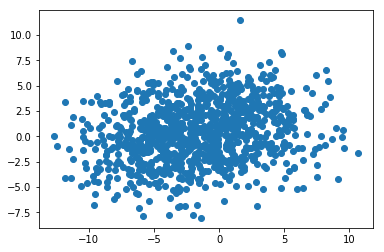

In [ ]:
plt.scatter(*generated['data'].T)

In [ ]:
loss, reset, emstep = mog_model.MAPEM_optimizer(data=generated['data'])
_, bfgs = mog_model.bfgs_optimizer(enhanced=False,data=generated['data'])
emproposal = mog_model.MAPEMsteps(data=generated['data'])
unitsteps = {key: mog_model.assigner(**{key:val}) for key, val in emproposal.items()}
testmodel = mog_model.test_model()#centeredMarginalizedIndependentFactorAnalysisTest(n_observations=n_observations, **ifa_model.variables)

In [ ]:
grad = {key: tf.gradients(loss, val) for key, val in mog_model.variables.items()}
cmap = plt.cm.Reds

In [ ]:
sess.run(tf.global_variables_initializer())
#init = dict(generated)
#init.pop('data')

#sess.run(ifa_model.assigner(**init))
subset = dict(unitsteps)
#subset.pop('mixture_component_precisions_cholesky')
subset = {key: val for key, val in unitsteps.items() if key in ['mixture_component_precisions_cholesky']}
#subset.pop('data_var')

its = 1000
losses = [sess.run(loss)]
grads = {key: [] for key in mog_model.variables.keys()}
loadings = []
plt.figure(figsize=(20,20))
for i in range(its):
    sess.run(reset)
    #sess.run(unitsteps['data_var'])
    #sess.run(reset)
    sess.run(subset)
    #if (i % 50) == 0:
    #    sess.run(unitsteps['data_var'])
    
    #sess.run(unitsteps['mixture_weights'])
    loadings.append(sess.run(mog_model.variables['factor_loadings']))
    #sess.run(reset)
    #sess.run(unitsteps['mixture_weights'])
    #sess.run(reset)
    #sess.run(unitsteps['data_var'])
    #print(sess.run(ifa_model.current['data_var']))
    loss_i,grad_i = sess.run([loss,grad])
    losses.append(loss_i)
    for key, val in grad_i.items():
        grads[key].append(np.max(np.abs(val)))
    if i>1 and (i % 100) == 0:
        plt.subplot(its//50,1,i//50+1)
        plt.scatter(*generated['data'].T,color='k',alpha=0.3)
        plt.scatter(*sess.run(testmodel).T,alpha=0.1,color='r')
        for l in loadings[-1]:
            plt.plot([-10*l[0],10*l[0]],[-10*l[1],10*l[1]],'r',lw=3)
        for l in generated['factor_loadings']:
            plt.plot([-10*l[0],10*l[0]],[-10*l[1],10*l[1]],'b--',lw=3)
#plt.axis([-5,5,-3,3])

In [ ]:
#plt.scatter(*generated['data'].T,color='k',alpha=0.3)
#plt.scatter(*sess.run(testmodel).T,alpha=0.1,color='r')
#for l in loadings[-1]:
#    plt.plot([-10*l[0],10*l[0]],[-10*l[1],10*l[1]],'r',lw=3,label='MAP')
#for l in generated['factor_loadings']:
#    plt.plot([-10*l[0],10*l[0]],[-10*l[1],10*l[1]],'b--',lw=3,label='True')
#plt.legend()

In [ ]:
plt.figure()
plt.plot(losses[5:])
## sign checks
plt.figure()
plt.plot((np.diff(losses)))
plt.hlines(0,0,100)
plt.ylim([-1,1])
plt.figure()
plt.plot(np.sign(np.diff(losses)) * (1. - np.isclose(0, np.diff(losses), atol=1e-10)))
plt.hlines(0,0,100)
plt.figure()
for key, val in grads.items():
    plt.semilogy(val, label=key)
plt.legend()


In [ ]:
for key, val in unitsteps.items():
    sess.run(reset)
    sess.run(val)
    print('{}: {}'.format(key, sess.run(grad)))